In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt

In [ ]:
lookback = 8 # lookback = 7，6，5，4，3，2，1
grid_width = 5 # 栅格化粒度（每个小单元格的边长）
time_interval = 15 # 时间间隔，可能取值15min、30min、60min

# 先用第一个数据集调参数，画不同参数下error或accuracy曲线
# 调完参数后，用各种lookback和time_interval，跑10个数据集，算训练集和测试集下F1、AUC的平均值，用于和其它模型比较

In [ ]:
# 始终先运行一遍这个

import random

geohash_map = pd.read_csv(u'drive/MyDrive/Capstone/data/poi_data.csv')
geohash_vec = geohash_map[[ u'Amenity', u'Bump', u'Crossing', u'Entrance', u'Give_Way',
       u'Junction', u'Noexit', u'Railway', u'Roundabout', u'Station', u'Stop',
       u'Traffic_Calming', u'Traffic_Signal', u'Turning_Circle',
       u'Turning_Loop']]

geohash_dict={}
for index, row in geohash_map.iterrows():
    geohash_dict[row.Geohash] = np.array(geohash_vec.iloc[index])

geo_dict = dict(zip(geohash_map.Geohash.unique(), range(len(geohash_map.Geohash.unique()))))

df = pd.read_csv(u'drive/MyDrive/Capstone/data/integrated_data_{}_{}.csv'.format(str(grid_width),str(time_interval)))

df = df [[u'TimeStep', u'predicted_accident',u'Geohash',u'geohash_code', u'DOW_cat', u'DayLight',
    u'HOD_en0', u'HOD_en1', u'HOD_en2', u'HOD_en3', u'HOD_en4', u'T-Accident',
    u'T-Congestion', u'T-Incident', u'T-Restriction', u'T-Obstruction',
    u'T-Activity', u'T-Equipment', u'T-Other', u'W-Humidity',
    u'W-Precipitation', u'W-Pressure', u'W-Temperature', u'W-Visibility',
    u'W-WindSpeed', u'W-Rain', u'W-Snow', u'W-Fog', u'W-Hail']]

print ("zero accident =",float(df[df['T-Accident']==0].shape[0])/df.shape[0])

train = df[df.TimeStep <= df.TimeStep.max()*0.8]
test = df[df.TimeStep > df.TimeStep.max()*0.8]
sampling_rate = float(train[train['T-Accident']==0].shape[0])/train.shape[0]

random.seed(996)

for t in range(0,10):

  X_train = []
  y_train = []

  for idx, frame in train.groupby(train.Geohash):

    current_frame = frame.values
    geo_vec = geohash_dict[frame.Geohash.iloc[0]]
    geo_code = geo_dict[frame.Geohash.iloc[0]]

    for i in range(lookback, current_frame.shape[0]):
        if current_frame[i, 1] > 0 :
            a = np.concatenate((current_frame[i-lookback:i,4:].flatten(),geo_vec),axis=0)
            a = np.append(a, geo_code)
            X_train.append(a)
            y_train.append(1)
            
        elif random.uniform(0, 1) > sampling_rate:  # negative sampling for non-accident cases 
            a = np.concatenate((current_frame[i-lookback:i,4:].flatten(),geo_vec),axis=0)
            a = np.append(a, geo_code)
            X_train.append(a)
            y_train.append(0)  
  
  X_train = np.array(X_train)
  y_train = np.array(y_train)

  X_test = []
  y_test = []

  for idx, frame in test.groupby(test.Geohash):

    current_frame = frame.values
    geo_vec = geohash_dict[frame.Geohash.iloc[0]]
    geo_code = geo_dict[frame.Geohash.iloc[0]]

    for i in range(lookback, current_frame.shape[0]):
        if current_frame[i, 1] > 0 :
            a = np.concatenate((current_frame[i-lookback:i,4:].flatten(),geo_vec),axis=0)
            a = np.append(a, geo_code)
            X_test.append(a)
            y_test.append(1)
            
        elif random.uniform(0, 1) > sampling_rate:  # negative sampling for non-accident cases 
            a = np.concatenate((current_frame[i-lookback:i,4:].flatten(),geo_vec),axis=0)
            a = np.append(a, geo_code)
            X_test.append(a)
            y_test.append(0)  
  
  X_test = np.array(X_test)
  y_test = np.array(y_test)

  np.save(u'X_train_' + str(t) + '.npy',X_train) 
  np.save(u'y_train_' + str(t) + '.npy',y_train)
  np.save(u'X_test_' + str(t) + '.npy',X_test)
  np.save(u'y_test_' + str(t) + '.npy',y_test)

zero accident = 0.9963450432479988


In [ ]:
#取第一个数据集

X_train = np.load('X_train_1.npy', allow_pickle=True)
y_train = np.load('y_train_1.npy', allow_pickle=True)

X_test = np.load('X_test_1.npy', allow_pickle=True)
y_test = np.load('y_test_1.npy', allow_pickle=True)

1-D tuning


(1) tuning C

In [ ]:
pipeline = Pipeline([
('sc', StandardScaler()),
('clf', LogisticRegression(penalty='l2',max_iter=10000))
])

parameters = {
'clf__C': (0.00001,0.0001,0.001,0.01, 0.1, 1, 10,100,1000),
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring='accuracy', cv=5)

grid_search.fit(X_train, y_train)
print(grid_search.best_params_, grid_search.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


{'clf__C': 0.001} 0.7551625450732367


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   24.8s finished


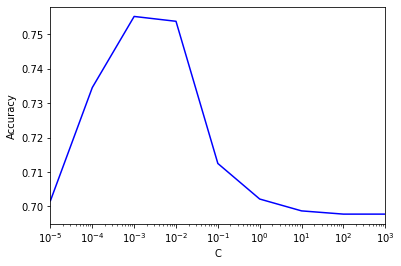

In [ ]:
record = []
C = [0.00001,0.0001,0.001,0.01, 0.1, 1, 10,100,1000]
for mean, params in zip(grid_search.cv_results_['mean_test_score'], grid_search.cv_results_['params']): 
  record.append(mean)
plt.plot(C, record, 'b')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.xlim(0.00001,1000)
plt.xscale('log')
plt.show()

best model without PCA

205    0.233986
209    0.215998
206    0.193556
212    0.155781
200    0.118454
dtype: float64


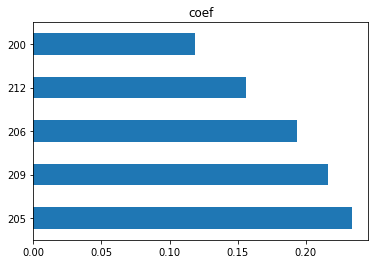

In [ ]:
pipeline = Pipeline([
('sc', StandardScaler()),
('clf', LogisticRegression(C = 0.001,penalty='l2',max_iter=10000))
])

pipeline.fit(X_train, y_train)

importance = pipeline['clf'].coef_[0]
feat_importances = pd.Series(importance)
feat_importances.nlargest(5).plot(kind='barh',title = 'coef')

print(feat_importances.nlargest(5))

# 183: 发生拥堵事件的次数
# 206: 禁止驶出标志数量
# 205: 交叉口数量
# 212: 信号灯数量
# 209: 车站数量

In [ ]:
! wget -O /usr/share/fonts/truetype/liberation/simhei.ttf "https://www.wfonts.com/download/data/2014/06/01/simhei/chinese.simhei.ttf"

/bin/bash:  wget -O /usr/share/fonts/truetype/liberation/simhei.ttf https://www.wfonts.com/download/data/2014/06/01/simhei/chinese.simhei.ttf: No such file or directory


In [ ]:
import matplotlib as mlp
import matplotlib.pyplot as plt
zhfont = mlp.font_manager.FontProperties(fname='/usr/share/fonts/truetype/liberation/simhei.ttf')

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20132 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21449 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21475 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25968 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 37327 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 36710 missing from current font.
  font.set_

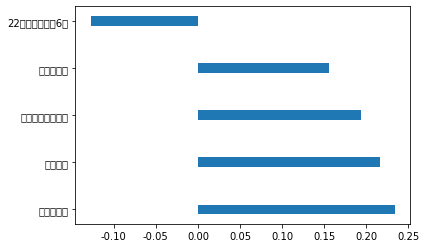

In [13]:
feature = ['交叉口数量','车站数量','禁止驶出标志数量','信号灯数量','22点至次日早上6点']
val = [0.233986,0.215998,0.193556,0.155781,-0.127587]
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.barh(feature,val,height=0.2)
plt.show()

181   -0.127587
156   -0.080224
5     -0.065413
30    -0.046415
131   -0.041013
dtype: float64


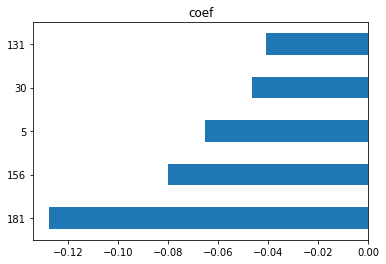

In [ ]:
print(feat_importances.nsmallest(5))
feat_importances.nsmallest(5).plot(kind='barh',title = 'coef')

# 70: 风速
# 169: 可见度
# 5: 18点至22点
# 181: 22点至6点
# 202: 6点至10点

（2）tuning explained variance in PCA

In [ ]:
pipeline = Pipeline([
('sc', StandardScaler()),
('pca', PCA()),
('clf', LogisticRegression(C=0.001,penalty='l2',max_iter=10000))
])

parameters = {
'pca__n_components': (0.8, 0.85, 0.9, 0.95,0.9999),
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring='accuracy', cv=5)

grid_search.fit(X_train, y_train)
print(grid_search.best_params_, grid_search.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    8.7s finished


{'pca__n_components': 0.95} 0.7570406017024744


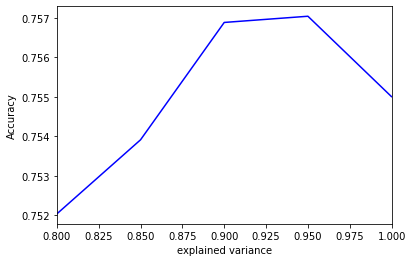

In [ ]:
record = []
n_comp = [0.8, 0.85, 0.9, 0.95,0.9999]
for mean, params in zip(grid_search.cv_results_['mean_test_score'], grid_search.cv_results_['params']): 
  record.append(mean)
plt.plot(n_comp, record, 'b')
plt.xlabel('explained variance')
plt.ylabel('Accuracy')
plt.xlim(0.8,1.0)
plt.show()

Performance under best parameters

In [ ]:
num_set = 10 #取10个数据集

F1_results = [] #10个数据集下的F1值
AUC_results = []
F1_train_results = []
AUC_train_results =[]

for t in range(num_set):

  X_train = np.load('X_train_' + str(t) +'.npy', allow_pickle=True)
  y_train = np.load('y_train_' + str(t) + '.npy', allow_pickle=True)

  #训练逻辑回归模型
  ####
  pipeline = Pipeline([
('sc', StandardScaler()),
('pca', PCA(n_components=0.9)),
('clf', LogisticRegression(C=0.001,penalty='l2',max_iter=10000))
])
  pipeline.fit(X_train,y_train)

  y_train_pred = pipeline.predict(X_train)
  F1_train = metrics.f1_score(y_train,y_train_pred)
  AUC_train =metrics.roc_auc_score(y_train,y_train_pred)

  F1_train_results.append(F1_train)
  AUC_train_results.append(AUC_train)

  X_test = np.load('X_test_' + str(t) + '.npy', allow_pickle=True)
  y_test = np.load('y_test_' + str(t) + '.npy', allow_pickle=True)

  #测试逻辑回归模型
  ####
  y_pred = pipeline.predict(X_test)
  F1 = metrics.f1_score(y_test,y_pred)
  AUC =metrics.roc_auc_score(y_test,y_pred)


  F1_results.append(F1) #当前数据集的F1
  AUC_results.append(AUC)

print(np.mean(F1_train_results)) #10个数据集的平均F1
print(np.mean(F1_results)) #10个数据集的平均F1
print(np.mean(AUC_train_results)) #10个数据集的平均F1
print(np.mean(AUC_results)) #10个数据集的平均F1

0.7711366194616716
0.7972893150468183
0.7773883553108734
0.7854015499076965


2-D tuning with PCA(90% explained vaiance)

In [ ]:
pipeline = Pipeline([
('sc', StandardScaler()),
('pca', PCA(n_components=0.9)),
('clf', LogisticRegression())
])

parameters = {
'clf__penalty': ('l1', 'l2'),
'clf__C': (0.01, 0.1, 1, 10),
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring='f1', cv=5)

grid_search.fit(x_train, y_train)

print('最佳效果：%0.3f' % grid_search.best_score_)
print('最优参数组合')
best_parameters=grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print('\t%s:%r' %(param_name,best_parameters[param_name]))

#print(grid_search.cv_results_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    8.4s finished


最佳效果：0.739
最优参数组合
	clf__C:1
	clf__penalty:'l2'
[       nan 0.7376859         nan 0.7378495         nan 0.73862073
        nan 0.73856383]


In [ ]:
print(grid_search.cv_results_)

{'mean_fit_time': array([0.2507833 , 0.2756216 , 0.23894997, 0.31767769, 0.24619112,
       0.32789369, 0.23160443, 0.31814303]), 'std_fit_time': array([0.02754942, 0.0151989 , 0.01356471, 0.02046967, 0.01999451,
       0.02887663, 0.01391372, 0.03815148]), 'mean_score_time': array([0.        , 0.0161171 , 0.        , 0.0136107 , 0.        ,
       0.01770215, 0.        , 0.01503301]), 'std_score_time': array([0.        , 0.00343125, 0.        , 0.00031124, 0.        ,
       0.00430375, 0.        , 0.00335389]), 'param_clf__C': masked_array(data=[0.01, 0.01, 0.1, 0.1, 1, 1, 10, 10],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_clf__penalty': masked_array(data=['l1', 'l2', 'l1', 'l2', 'l1', 'l2', 'l1', 'l2'],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'clf__C': 0.01, 'clf__penalty': 'l1'}, {'clf__C': 0.01,

best model with PCA

In [ ]:
pipeline = Pipeline([
('sc', StandardScaler()),
('pca', PCA(n_components=0.9)),
('clf', LogisticRegression(C=1,penalty='l2',max_iter=10000))
])

pipeline.fit(x_train,y_train)
fls=cross_val_score(pipeline,x_train,y_train,cv=5,scoring='f1')
print('综合指标评价',np.mean(fls),fls)
fls=cross_val_score(pipeline,x_train,y_train,cv=5,scoring='accuracy')
print('accuracy',np.mean(fls),fls)

pred = pipeline.predict(x_test)
metrics.accuracy_score(y_test,pred)

综合指标评价 0.7386207332128844 [0.69310345 0.75230898 0.723116   0.81376215 0.71081308]
accuracy 0.7642510327731857 [0.73313343 0.77886057 0.75487256 0.8132033  0.7411853 ]


0.7759197324414716

In [ ]:
pipeline['clf'].coef_

array([[-1.09494116e-01,  2.77206866e-01,  4.23205798e-01,
        -7.93176053e-02,  6.72083502e-02, -6.50442708e-02,
        -3.15440450e-01, -2.78308484e-02, -1.07162214e-01,
         1.41962007e-01,  1.47415628e-01,  2.20868961e-01,
         3.38618776e-01,  3.42257126e-01, -8.11157811e-02,
        -3.03357131e-01, -1.22230405e-01, -9.68098194e-02,
         1.04398118e-02, -7.75590704e-03, -1.24643553e-02,
        -9.84799929e-03, -5.55276787e-02,  1.29782462e-01,
        -9.83754964e-02,  1.03406536e-01,  6.14638400e-02,
         3.63088683e-01,  4.60617683e-02,  2.19051016e-03,
        -1.06778084e-02, -1.05861415e-03,  3.27896917e-01,
         9.82588361e-04,  1.23751166e-01,  1.09664619e-01,
        -9.05086800e-04,  2.89137384e-02,  4.37920611e-02,
        -1.04974989e-01, -1.10048894e-01, -1.86893480e-01,
        -1.10751754e-01,  2.15948905e-04, -6.08626592e-02,
         9.19265887e-03, -1.49100988e-01,  1.94109080e-02]])